# TRAINING

In [1]:
import torch
import numpy as np
import pickle

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Product, ConstantKernel as C

import gym_sin
from gym import spaces

from active_learning.arguments import get_args
from active_learning.oracle import OracleAgent
from active_learning.posterior_multi_task import PosteriorMTAgent
from network.vae import InferenceNetwork, InferenceNetwork2, InferenceNetworkNoPrev, InferenceNetworkDirectlyRec
from task.GuassianTaskGenerator import GaussianTaskGenerator
from utilities.folder_management import handle_folder_creation


In [56]:
def get_const_task_sequence(alpha, n_restarts, num_test_processes):
    kernel = C(1.0, (1e-5, 1e5)) * RBF(1, (1e-5, 1e5))

    gp_list = []
    for i in range(2):
        gp_list.append([GaussianProcessRegressor(kernel=kernel,
                                                 alpha=alpha ** 2,
                                                 normalize_y=True,
                                                 n_restarts_optimizer=n_restarts)
                        for _ in range(num_test_processes)])
    test_kwargs = []
    init_prior_test = [torch.tensor([[-10], [10]], dtype=torch.float32) for _ in range(num_test_processes)]
        
    mean = -15
    std = 15
    
    for idx in range(50):
        test_kwargs.append({'amplitude': 1,
                            'mean': mean,
                            'std': std,
                            'noise_std': 0.001,
                            'scale_reward': False})

    return gp_list, test_kwargs, init_prior_test

def get_linear_task_sequence(alpha, n_restarts, num_test_processes):
    kernel = C(1.0, (1e-5, 1e5)) * RBF(1, (1e-5, 1e5))

    gp_list = []
    for i in range(2):
        gp_list.append([GaussianProcessRegressor(kernel=kernel,
                                                 alpha=alpha ** 2,
                                                 normalize_y=True,
                                                 n_restarts_optimizer=n_restarts)
                        for _ in range(num_test_processes)])
    test_kwargs = []
    init_prior_test = [torch.tensor([[30], [5]], dtype=torch.float32) for _ in range(num_test_processes)]

    for idx in range(50):
        std = 15
        mean = 30 - idx
        
        test_kwargs.append({'amplitude': 1,
                            'mean': mean,
                            'std': std,
                            'noise_std': 0.001,
                            'scale_reward': False})

    return gp_list, test_kwargs, init_prior_test

def get_phase_task_sequence(alpha, n_restarts, num_test_processes):
    kernel = C(1.0, (1e-5, 1e5)) * RBF(1, (1e-5, 1e5))

    gp_list = []
    for i in range(2):
        gp_list.append([GaussianProcessRegressor(kernel=kernel,
                                                 alpha=alpha ** 2,
                                                 normalize_y=True,
                                                 n_restarts_optimizer=n_restarts)
                        for _ in range(num_test_processes)])
    test_kwargs = []
    init_prior_test = [torch.tensor([[-5], [5]], dtype=torch.float32) for _ in range(num_test_processes)]

    for idx in range(50):
        if idx < 15:
            std = 15
            mean = 0
        elif idx < 30:
            std = 15
            mean = 10
        else:
            std = 15
            mean = 0
            
        test_kwargs.append({'amplitude': 1,
                            'mean': mean,
                            'std': std,
                            'noise_std': 0.001,
                            'scale_reward': False})

    return gp_list, test_kwargs, init_prior_test

In [4]:
env_name = "gauss-v0"

action_space = spaces.Box(low=np.array([-1]), high=np.array([1]))
latent_dim = 1

x_min = -100
x_max = 100

min_mean = -40
max_mean = 40

prior_mu_min = -10
prior_mu_max = 10
prior_std_min = 1
prior_std_max = 10

std = 15
amplitude=1

device = "cpu"

In [5]:
task_generator = GaussianTaskGenerator(x_min, x_max, min_mean, max_mean,
                 prior_mu_min, prior_mu_max, prior_std_min, prior_std_max, std, amplitude)
fam = task_generator.create_task_family(n_tasks=5000, n_batches=1, test_perc=0, batch_size=150)

In [6]:
max_old = [100, 10]
min_old = [-100, 0]
# max_old = None
# min_old = None

vae_min_seq = 1
vae_max_seq = 150

obs_shape = (2,)

In [8]:
vi = InferenceNetworkDirectlyRec(n_in=4, z_dim=latent_dim)
vi_optim = torch.optim.Adam(vi.parameters(), lr=1e-3)
vi = torch.load("vae")

In [11]:
agent = PosteriorMTAgent(action_space=action_space, device=device, gamma=0.999,
                                 num_steps=150, num_processes=32,
                                 clip_param=0.2, ppo_epoch=4,
                                 num_mini_batch=8,
                                 value_loss_coef=0.5,
                                 entropy_coef=0.,
                                 lr=0.0001,
                                 eps=1e-6, max_grad_norm=0.5,
                                 use_linear_lr_decay=False,
                                 use_gae=False,
                                 gae_lambda=0.95,
                                 use_proper_time_limits=False,
                                 obs_shape=obs_shape,
                                 latent_dim=latent_dim,
                                 recurrent_policy=False,
                                 hidden_size=16,
                                 use_elu=True,
                                 variational_model=vi,
                                 vae_optim=vi_optim,
                                 rescale_obs=True,
                                 max_old=max_old,
                                 min_old=min_old,
                                 vae_min_seq=vae_min_seq,
                                 vae_max_seq=vae_max_seq,
                                 max_action=100,
                                 min_action=-100,
                        use_time=False, rescale_time=None, max_time=None)

In [12]:
gp_list, test_kwargs, init_prior_test = get_task_sequence(alpha=0.25,
                                                          n_restarts=1,
                                                          num_test_processes=2)
res_eval, res_vae, test_list = agent.train(training_iter=5000,
                                           env_name=env_name,
                                           seed=0,
                                           task_generator=task_generator,
                                           eval_interval=10,
                                           log_dir=".",
                                           use_env_obs=False,
                                           num_vae_steps=0,
                                           init_vae_steps=0,
                                           gp_list=gp_list,
                                           sw_size=20,
                                           test_kwargs=test_kwargs,
                                           init_prior_test=init_prior_test,
                                           num_random_task_to_eval=32,
                                           num_test_processes=2)

Epoch 10 / 5000
Evaluation...
Evaluation using 32 tasks. Mean reward: 14.7120813125
Meta-testing...
Reward : 15.615929589999999
Epoch 20 / 5000
Evaluation...
Evaluation using 32 tasks. Mean reward: 14.5654204375
Meta-testing...
Reward : 15.735017990000001
Epoch 30 / 5000
Evaluation...
Evaluation using 32 tasks. Mean reward: 14.91822646875
Meta-testing...
Reward : 15.55496981
Epoch 40 / 5000
Evaluation...
Evaluation using 32 tasks. Mean reward: 15.716872125000002
Meta-testing...
Reward : 15.97074888
Epoch 50 / 5000
Evaluation...
Evaluation using 32 tasks. Mean reward: 15.53015859375
Meta-testing...
Reward : 16.57286815
Epoch 60 / 5000
Evaluation...
Evaluation using 32 tasks. Mean reward: 15.8029325625
Meta-testing...
Reward : 16.546474259999997
Epoch 70 / 5000
Evaluation...
Evaluation using 32 tasks. Mean reward: 16.968097531250002
Meta-testing...
Reward : 17.12333139
Epoch 80 / 5000
Evaluation...
Evaluation using 32 tasks. Mean reward: 16.735965593750002
Meta-testing...
Reward : 17.447

C:\Users\Riccardo\Anaconda3\envs\sequential-transfer-rl\lib\site-packages\sklearn\gaussian_process\_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Reward : 27.31793703
Epoch 650 / 5000
Evaluation...
Evaluation using 32 tasks. Mean reward: 28.87794125
Meta-testing...
Reward : 28.660880040000002
Epoch 660 / 5000
Evaluation...
Evaluation using 32 tasks. Mean reward: 26.825423
Meta-testing...
Reward : 26.220447139999997
Epoch 670 / 5000
Evaluation...
Evaluation using 32 tasks. Mean reward: 30.9146696875
Meta-testing...
Reward : 29.528671740000004
Epoch 680 / 5000
Evaluation...
Evaluation using 32 tasks. Mean reward: 29.55109434375
Meta-testing...
Reward : 29.453481469999996
Epoch 690 / 5000
Evaluation...
Evaluation using 32 tasks. Mean reward: 30.917896562499998
Meta-testing...
Reward : 30.3640608
Epoch 700 / 5000
Evaluation...
Evaluation using 32 tasks. Mean reward: 30.370217906249998
Meta-testing...
Reward : 30.070911350000003
Epoch 710 / 5000
Evaluation...
Evaluation using 32 tasks. Mean reward: 31.79975378125
Meta-testing...
Reward : 29.964172180000006
Epoch 720 / 5000
Evaluation...
Evaluation using 32 tasks. Mean reward: 30.9773

C:\Users\Riccardo\Anaconda3\envs\sequential-transfer-rl\lib\site-packages\sklearn\gaussian_process\_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Reward : 38.499436720000006
Epoch 1110 / 5000
Evaluation...
Evaluation using 32 tasks. Mean reward: 39.606398812500004
Meta-testing...
Reward : 39.11903926
Epoch 1120 / 5000
Evaluation...
Evaluation using 32 tasks. Mean reward: 39.6172239375
Meta-testing...
Reward : 38.449057339999996
Epoch 1130 / 5000
Evaluation...
Evaluation using 32 tasks. Mean reward: 41.295616781250004
Meta-testing...
Reward : 39.19722864
Epoch 1140 / 5000
Evaluation...
Evaluation using 32 tasks. Mean reward: 41.2399014375
Meta-testing...
Reward : 39.19849687
Epoch 1150 / 5000
Evaluation...
Evaluation using 32 tasks. Mean reward: 40.8059756875
Meta-testing...
Reward : 39.3388138
Epoch 1160 / 5000
Evaluation...
Evaluation using 32 tasks. Mean reward: 41.40761203125
Meta-testing...
Reward : 39.555031160000006
Epoch 1170 / 5000
Evaluation...
Evaluation using 32 tasks. Mean reward: 41.6165168125
Meta-testing...
Reward : 39.270282429999995
Epoch 1180 / 5000
Evaluation...
Evaluation using 32 tasks. Mean reward: 41.82211

C:\Users\Riccardo\Anaconda3\envs\sequential-transfer-rl\lib\site-packages\sklearn\gaussian_process\_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Reward : 51.25295142
Epoch 1620 / 5000
Evaluation...
Evaluation using 32 tasks. Mean reward: 55.297834593750004
Meta-testing...
Reward : 53.10436516
Epoch 1630 / 5000
Evaluation...
Evaluation using 32 tasks. Mean reward: 57.06181759375
Meta-testing...
Reward : 54.96764405
Epoch 1640 / 5000
Evaluation...
Evaluation using 32 tasks. Mean reward: 57.589300625
Meta-testing...
Reward : 53.21602811
Epoch 1650 / 5000
Evaluation...
Evaluation using 32 tasks. Mean reward: 56.68001225
Meta-testing...
Reward : 54.33222277
Epoch 1660 / 5000
Evaluation...
Evaluation using 32 tasks. Mean reward: 57.094816156250005
Meta-testing...
Reward : 54.65466023999999
Epoch 1670 / 5000
Evaluation...
Evaluation using 32 tasks. Mean reward: 56.10137265625
Meta-testing...
Reward : 55.35598436999999
Epoch 1680 / 5000
Evaluation...
Evaluation using 32 tasks. Mean reward: 56.70739084375
Meta-testing...
Reward : 55.42640636000001
Epoch 1690 / 5000
Evaluation...
Evaluation using 32 tasks. Mean reward: 58.3271898125
Meta

Evaluation using 32 tasks. Mean reward: 72.5646306875
Meta-testing...
Reward : 70.86545022
Epoch 2270 / 5000
Evaluation...
Evaluation using 32 tasks. Mean reward: 72.96170140625
Meta-testing...
Reward : 69.75805328
Epoch 2280 / 5000
Evaluation...
Evaluation using 32 tasks. Mean reward: 75.85478578125
Meta-testing...
Reward : 69.05512377
Epoch 2290 / 5000
Evaluation...
Evaluation using 32 tasks. Mean reward: 76.04567065625
Meta-testing...
Reward : 72.96142747
Epoch 2300 / 5000
Evaluation...
Evaluation using 32 tasks. Mean reward: 76.34722321875
Meta-testing...
Reward : 70.15755559
Epoch 2310 / 5000
Evaluation...
Evaluation using 32 tasks. Mean reward: 76.716997125
Meta-testing...
Reward : 71.64117245999999
Epoch 2320 / 5000
Evaluation...
Evaluation using 32 tasks. Mean reward: 76.15452509375001
Meta-testing...
Reward : 68.00392053
Epoch 2330 / 5000
Evaluation...
Evaluation using 32 tasks. Mean reward: 73.95922321875
Meta-testing...
Reward : 63.905408349999995
Epoch 2340 / 5000
Evaluatio

C:\Users\Riccardo\Anaconda3\envs\sequential-transfer-rl\lib\site-packages\sklearn\gaussian_process\_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Reward : 66.89216614
Epoch 2450 / 5000
Evaluation...
Evaluation using 32 tasks. Mean reward: 79.72241634375
Meta-testing...
Reward : 74.4450723
Epoch 2460 / 5000
Evaluation...
Evaluation using 32 tasks. Mean reward: 79.26833375000001
Meta-testing...
Reward : 68.7972959
Epoch 2470 / 5000
Evaluation...
Evaluation using 32 tasks. Mean reward: 80.29498115625
Meta-testing...
Reward : 71.12489737
Epoch 2480 / 5000
Evaluation...
Evaluation using 32 tasks. Mean reward: 82.0554070625
Meta-testing...
Reward : 74.80359367999999
Epoch 2490 / 5000
Evaluation...
Evaluation using 32 tasks. Mean reward: 81.770529125
Meta-testing...
Reward : 74.53117211
Epoch 2500 / 5000
Evaluation...
Evaluation using 32 tasks. Mean reward: 83.30710425000001
Meta-testing...
Reward : 74.69225611
Epoch 2510 / 5000
Evaluation...
Evaluation using 32 tasks. Mean reward: 84.08775771875
Meta-testing...
Reward : 75.98178668999999
Epoch 2520 / 5000
Evaluation...
Evaluation using 32 tasks. Mean reward: 84.18899553125
Meta-testin

Reward : 87.84354614000002
Epoch 3100 / 5000
Evaluation...
Evaluation using 32 tasks. Mean reward: 100.37777693750002
Meta-testing...
Reward : 84.55475793999999
Epoch 3110 / 5000
Evaluation...
Evaluation using 32 tasks. Mean reward: 101.43595846875
Meta-testing...
Reward : 88.65362475999999
Epoch 3120 / 5000
Evaluation...
Evaluation using 32 tasks. Mean reward: 100.98513453125
Meta-testing...
Reward : 88.56882033000002
Epoch 3130 / 5000
Evaluation...
Evaluation using 32 tasks. Mean reward: 102.34400231250001
Meta-testing...
Reward : 91.36527641
Epoch 3140 / 5000
Evaluation...
Evaluation using 32 tasks. Mean reward: 101.84318878124999
Meta-testing...
Reward : 88.78815772999998
Epoch 3150 / 5000
Evaluation...
Evaluation using 32 tasks. Mean reward: 101.98091409375002
Meta-testing...
Reward : 88.75848751000001
Epoch 3160 / 5000
Evaluation...
Evaluation using 32 tasks. Mean reward: 101.56605596874999
Meta-testing...
Reward : 90.94950606
Epoch 3170 / 5000
Evaluation...
Evaluation using 32 t

Epoch 3730 / 5000
Evaluation...
Evaluation using 32 tasks. Mean reward: 114.88892078125
Meta-testing...
Reward : 98.02683227
Epoch 3740 / 5000
Evaluation...
Evaluation using 32 tasks. Mean reward: 115.81318706249999
Meta-testing...


C:\Users\Riccardo\Anaconda3\envs\sequential-transfer-rl\lib\site-packages\sklearn\gaussian_process\_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Reward : 98.92844907
Epoch 3750 / 5000
Evaluation...
Evaluation using 32 tasks. Mean reward: 115.90967215625
Meta-testing...
Reward : 96.46408454
Epoch 3760 / 5000
Evaluation...
Evaluation using 32 tasks. Mean reward: 111.19113243749999
Meta-testing...
Reward : 96.53419923000001
Epoch 3770 / 5000
Evaluation...
Evaluation using 32 tasks. Mean reward: 114.893833
Meta-testing...
Reward : 96.92030892000001
Epoch 3780 / 5000
Evaluation...
Evaluation using 32 tasks. Mean reward: 116.24162953125
Meta-testing...
Reward : 96.86661247
Epoch 3790 / 5000
Evaluation...
Evaluation using 32 tasks. Mean reward: 114.807742375
Meta-testing...
Reward : 95.49132424999999
Epoch 3800 / 5000
Evaluation...
Evaluation using 32 tasks. Mean reward: 115.44596828125
Meta-testing...
Reward : 98.08405081000001
Epoch 3810 / 5000
Evaluation...
Evaluation using 32 tasks. Mean reward: 114.85689012499999
Meta-testing...
Reward : 102.75146685000001
Epoch 3820 / 5000
Evaluation...
Evaluation using 32 tasks. Mean reward: 11

Reward : 110.73206798999999
Epoch 4390 / 5000
Evaluation...
Evaluation using 32 tasks. Mean reward: 123.955311
Meta-testing...
Reward : 103.70876980999999
Epoch 4400 / 5000
Evaluation...
Evaluation using 32 tasks. Mean reward: 124.44836587500001
Meta-testing...
Reward : 107.65942209
Epoch 4410 / 5000
Evaluation...
Evaluation using 32 tasks. Mean reward: 122.69940315625
Meta-testing...
Reward : 108.1720589
Epoch 4420 / 5000
Evaluation...
Evaluation using 32 tasks. Mean reward: 120.48003278125
Meta-testing...
Reward : 108.8446791
Epoch 4430 / 5000
Evaluation...
Evaluation using 32 tasks. Mean reward: 120.362386125
Meta-testing...
Reward : 102.76910861
Epoch 4440 / 5000
Evaluation...
Evaluation using 32 tasks. Mean reward: 126.13902518750001
Meta-testing...
Reward : 104.27460901999999
Epoch 4450 / 5000
Evaluation...
Evaluation using 32 tasks. Mean reward: 126.44149346875
Meta-testing...
Reward : 103.75830592999999
Epoch 4460 / 5000
Evaluation...
Evaluation using 32 tasks. Mean reward: 126

In [13]:
gp_list, test_kwargs, init_prior_test = get_task_sequence(alpha=0.25,
                                                          n_restarts=1,
                                                          num_test_processes=2)
res_eval_2, res_vae_2, test_list_2 = agent.train(training_iter=1000,
                                           env_name=env_name,
                                           seed=0,
                                           task_generator=task_generator,
                                           eval_interval=10,
                                           log_dir=".",
                                           use_env_obs=False,
                                           num_vae_steps=0,
                                           init_vae_steps=0,
                                           gp_list=gp_list,
                                           sw_size=20,
                                           test_kwargs=test_kwargs,
                                           init_prior_test=init_prior_test,
                                           num_random_task_to_eval=32,
                                           num_test_processes=2)

Epoch 10 / 1000
Evaluation...
Evaluation using 32 tasks. Mean reward: 129.29572296875
Meta-testing...
Reward : 107.39922589999998
Epoch 20 / 1000
Evaluation...
Evaluation using 32 tasks. Mean reward: 129.56641640625003
Meta-testing...
Reward : 105.4585322
Epoch 30 / 1000
Evaluation...
Evaluation using 32 tasks. Mean reward: 127.17479078125001
Meta-testing...
Reward : 95.95816710999998
Epoch 40 / 1000
Evaluation...
Evaluation using 32 tasks. Mean reward: 126.953231
Meta-testing...
Reward : 93.47031548
Epoch 50 / 1000
Evaluation...
Evaluation using 32 tasks. Mean reward: 130.2305094375
Meta-testing...
Reward : 91.98985889
Epoch 60 / 1000
Evaluation...
Evaluation using 32 tasks. Mean reward: 128.3828888125
Meta-testing...
Reward : 114.12277649999999
Epoch 70 / 1000
Evaluation...
Evaluation using 32 tasks. Mean reward: 128.8861175625
Meta-testing...
Reward : 108.17144183999999
Epoch 80 / 1000
Evaluation...
Evaluation using 32 tasks. Mean reward: 131.7100384375
Meta-testing...
Reward : 112.

C:\Users\Riccardo\Anaconda3\envs\sequential-transfer-rl\lib\site-packages\sklearn\gaussian_process\_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Reward : 100.9864438
Epoch 100 / 1000
Evaluation...
Evaluation using 32 tasks. Mean reward: 129.8944413125
Meta-testing...
Reward : 91.40461998999999
Epoch 110 / 1000
Evaluation...
Evaluation using 32 tasks. Mean reward: 131.03116206250002
Meta-testing...
Reward : 86.83453924
Epoch 120 / 1000
Evaluation...
Evaluation using 32 tasks. Mean reward: 132.02483309375
Meta-testing...
Reward : 108.6794275
Epoch 130 / 1000
Evaluation...
Evaluation using 32 tasks. Mean reward: 127.240895625
Meta-testing...
Reward : 88.81046489
Epoch 140 / 1000
Evaluation...
Evaluation using 32 tasks. Mean reward: 126.84361924999999
Meta-testing...
Reward : 74.03325411
Epoch 150 / 1000
Evaluation...
Evaluation using 32 tasks. Mean reward: 131.09570903125
Meta-testing...
Reward : 96.69459053
Epoch 160 / 1000
Evaluation...
Evaluation using 32 tasks. Mean reward: 130.50789228125
Meta-testing...
Reward : 107.1136788
Epoch 170 / 1000
Evaluation...
Evaluation using 32 tasks. Mean reward: 132.62107146875002
Meta-testing

Evaluation using 32 tasks. Mean reward: 130.21402353125
Meta-testing...
Reward : 96.11500164
Epoch 750 / 1000
Evaluation...
Evaluation using 32 tasks. Mean reward: 126.96407165625
Meta-testing...
Reward : 71.67166413
Epoch 760 / 1000
Evaluation...
Evaluation using 32 tasks. Mean reward: 123.65866940625
Meta-testing...
Reward : 68.68071144000001
Epoch 770 / 1000
Evaluation...
Evaluation using 32 tasks. Mean reward: 123.40877490624999
Meta-testing...
Reward : 86.79056349999999
Epoch 780 / 1000
Evaluation...
Evaluation using 32 tasks. Mean reward: 124.87399365625001
Meta-testing...
Reward : 75.14085674
Epoch 790 / 1000
Evaluation...
Evaluation using 32 tasks. Mean reward: 121.95832156249999
Meta-testing...
Reward : 72.73329894
Epoch 800 / 1000
Evaluation...
Evaluation using 32 tasks. Mean reward: 132.19883518749998
Meta-testing...
Reward : 74.55296735
Epoch 810 / 1000
Evaluation...
Evaluation using 32 tasks. Mean reward: 134.1084278125
Meta-testing...
Reward : 110.26168977000002
Epoch 820

In [14]:
torch.save(agent.actor_critic, "ptmt_actor_critic")

# META-TESTING

In [52]:
from functools import reduce

import numpy as np
import torch

from sklearn.gaussian_process import GaussianProcessRegressor
from active_learning.observation_utils import augment_obs_posterior, get_posterior_no_prev
from network.vae_utils import loss_inference_closed_form
from ppo_a2c.algo.ppo import PPO
from ppo_a2c.envs import make_vec_envs_multi_task
from ppo_a2c.model import MLPBase, Policy
from ppo_a2c.storage import RolloutStorage
import matplotlib.pyplot as plt

def temp_test_task_sequence(agent, gp_list, sw_size, env_name, seed, log_dir, envs_kwargs_list, init_prior, use_env_obs,
                            num_eval_processes):
    print("Meta-testing...")

    num_tasks = len(envs_kwargs_list)

    eval_episode_rewards = []
    prediction_mean = []

    prior = init_prior
    posterior_history = torch.empty(num_tasks, num_eval_processes, 2 * agent.latent_dim)

    for t, kwargs in enumerate(envs_kwargs_list):
        # Task creation
        temp = [kwargs for _ in range(num_eval_processes)]
        eval_envs = make_vec_envs_multi_task(env_name, seed, num_eval_processes, agent.gamma, log_dir, agent.device,
                                             False, temp, num_frame_stack=None)

        obs = eval_envs.reset()
        obs = augment_obs_posterior(obs, agent.latent_dim, prior,
                                    use_env_obs, rescale_obs=agent.rescale_obs,
                                    max_old=agent.max_old, min_old=agent.min_old)

        eval_recurrent_hidden_states = torch.zeros(
            num_eval_processes, agent.actor_critic.recurrent_hidden_state_size, device=agent.device)
        eval_masks = torch.zeros(num_eval_processes, 1, device=agent.device)

        use_prev_state = False

        task_epi_rewards = []

        while len(task_epi_rewards) < num_eval_processes:
            with torch.no_grad():
                _, action, _, eval_recurrent_hidden_states = agent.actor_critic.act(
                    obs,
                    eval_recurrent_hidden_states,
                    eval_masks,
                    deterministic=False)

            # Observe reward and next obs
            obs, reward, done, infos = eval_envs.step(action)
            posterior = get_posterior_no_prev(agent.vae, action, reward, prior,
                                              min_action=agent.min_action, max_action=agent.max_action,
                                              use_prev_state=use_prev_state)
            obs = augment_obs_posterior(obs, agent.latent_dim, posterior,
                                        use_env_obs, rescale_obs=agent.rescale_obs,
                                        max_old=agent.max_old, min_old=agent.min_old)

            use_prev_state = True
            eval_masks = torch.tensor(
                [[0.0] if done_ else [1.0] for done_ in done],
                dtype=torch.float32,
                device=agent.device)

            for info in infos:
                if 'episode' in info.keys():
                    total_epi_reward = info['episode']['r']
                    task_epi_rewards.append(total_epi_reward)

        eval_episode_rewards.append(np.mean(task_epi_rewards))
        eval_envs.close()

        # Retrieve new prior for the identified model so far
        posterior_history[t, :, :] = posterior
        x = np.atleast_2d(np.arange(t + 1)).T
        for dim in range(agent.latent_dim):
            for proc in range(num_eval_processes):
                if t > sw_size:
                    gp_list[dim][proc].fit(x[-sw_size:],
                                           np.atleast_2d(
                                               posterior_history[t + 1 - sw_size:t + 1, proc, dim].numpy()).T)
                else:
                    gp_list[dim][proc].fit(x,
                                           np.atleast_2d(posterior_history[0:t + 1, proc, dim].numpy()).T)

        prior = []
        curr_pred = []
        for proc in range(num_eval_processes):
            prior_proc = torch.empty(agent.latent_dim, 2)
            for dim in range(agent.latent_dim):
                x_points = np.atleast_2d(np.array([t+1])).T
                y_pred, sigma = gp_list[dim][proc].predict(x_points, return_std=True)
                prior_proc[0, 0] = y_pred[0, 0]
                prior_proc[0, 1] = sigma[0]
                curr_pred.append(y_pred[0][0])
            prior.append(prior_proc)
        prediction_mean.append(np.mean(curr_pred))
        # y = [envs_kwargs_list[j]['mean'] for j in range(t+1)]
        # plot_gp(gp_list[0][0], y, t+1)
    return eval_episode_rewards, posterior_history, prediction_mean


def plot_gp(gp, y, max_round_so_far):
    x = np.arange(max_round_so_far)
    x = np.atleast_2d(x).T
    y_pred, sigma = gp.predict(x, return_std=True)
    
    plt.figure()
    plt.plot(x, y, 'r.', markersize=10, label='Observations')
    plt.plot(x, y_pred, 'b-', label='Prediction')
    plt.fill(np.concatenate([x, x[::-1]]),
             np.concatenate([y_pred - 1.9600 * sigma,
                            (y_pred + 1.9600 * sigma)[::-1]]),
             alpha=.5, fc='b', ec='None', label='95% confidence interval')
    plt.ylim(-10, 50)
    plt.show()

def plot_results(res, test_kwargs, posterior_history, gp_pred):
    # Plot reward
    plt.plot(res)
    plt.show()

    # Retrieve env data
    a_list = [test_kwargs[i]['mean'] for i in range(len(test_kwargs))]
    std_list = [test_kwargs[i]['std'] for i in range(len(test_kwargs))]
    
    # Compare posterior with real tasks
    gp_pred.insert(0, gp_pred[0])
    plt.plot(gp_pred, label="GP pred")
    plt.plot(a_list, label="True task")
    plt.plot(posterior_history[:, 0, 0], label="Posterior")
    plt.legend()
    plt.show()

Meta-testing...


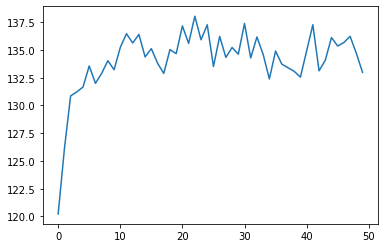

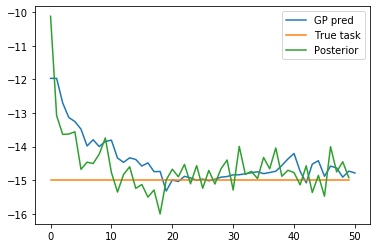

In [53]:
gp_list, test_kwargs, init_prior_test = get_const_task_sequence(0.25, 1, 2)
res, posterior_history, gp_pred = temp_test_task_sequence(agent, gp_list, 10, env_name, 0, ".", test_kwargs, init_prior_test, False, 2)
plot_results(res, test_kwargs, posterior_history, gp_pred)

Meta-testing...


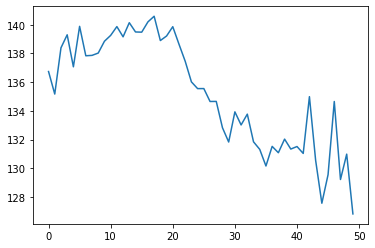

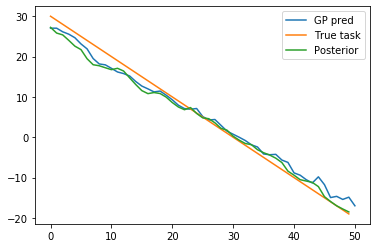

In [55]:
gp_list, test_kwargs, init_prior_test = get_linear_task_sequence(0.25, 1, 2)
res, posterior_history, gp_pred = temp_test_task_sequence(agent, gp_list, 10, env_name, 0, ".", test_kwargs, init_prior_test, False, 2)
plot_results(res, test_kwargs, posterior_history, gp_pred)

Meta-testing...


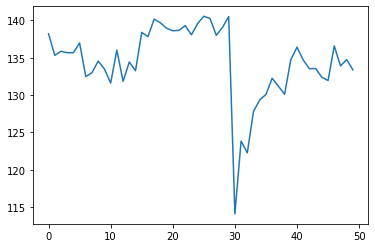

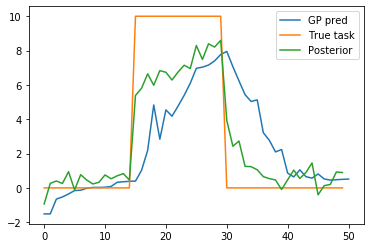

In [57]:
gp_list, test_kwargs, init_prior_test = get_phase_task_sequence(0.25, 1, 2)
res, posterior_history, gp_pred = temp_test_task_sequence(agent, gp_list, 10, env_name, 0, ".", test_kwargs, init_prior_test, False, 2)
plot_results(res, test_kwargs, posterior_history, gp_pred)